In [1]:
import os
import xarray
import earthaccess
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import user credentials and set for earthaccess login
import creds
os.environ["EARTHDATA_USERNAME"] = creds.username
os.environ["EARTHDATA_PASSWORD"] = creds.password

# login to earthacces
auth = earthaccess.login(strategy="environment")

In [2]:
# Search and locate granules
granule_info = earthaccess.search_data(
    short_name="SWOT_L4_DAWG_SOS_DISCHARGE",
    temporal=("2023-04-07", "2023-04-26"),
)
granule_info

[Collection: {'Version': '1', 'ShortName': 'SWOT_L4_DAWG_SOS_DISCHARGE'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -166.397, 'SouthBoundingCoordinate': 8.09, 'EastBoundingCoordinate': 8.09, 'NorthBoundingCoordinate': 82.311}]}}}
 Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-04-20T05:36:29.000Z', 'BeginningDateTime': '2023-03-29T08:52:24.000Z'}}
 Size(MB): 1927.0171918869019
 Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/na_sword_v16_SOS_unconstrained_0001_20240611T010141_results.nc', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/na_sword_v16_SOS_unconstrained_0001_20240611T010141_priors.nc'],
 Collection: {'Version': '1', 'ShortName': 'SWOT_L4_DAWG_SOS_DISCHARGE'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -166.397, 'SouthB

Read the SoS `reach` data into memory using xarray's lazy loading capability. This may take a minute or two, but it's important to note that these data are *not* being downloaded from the cloud. This is advantageous given the amount of data we're working with and considering the time it would take to download the requisite data.

This dataset consists of the following groups

> reaches  
nodes  
prediagnostics  
momma  
hivdi  
neobam  
metroman  
sic4dvar  
sad  
moi  
offline  
postdiagnostics  
validation  

In [3]:
%%time

files = earthaccess.open(granule_info)

QUEUEING TASKS | :   0%|          | 0/18 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/18 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/18 [00:00<?, ?it/s]

CPU times: user 108 ms, sys: 39.7 ms, total: 148 ms
Wall time: 3.57 s


In [4]:
%%time

ds_reaches = xarray.open_dataset(files[4],
                                 group='reaches',
                                 engine='h5netcdf',
                                 decode_cf=False,    
                                 decode_times=False, 
                                 decode_coords=False)
ds_reaches

CPU times: user 2.29 s, sys: 1.05 s, total: 3.35 s
Wall time: 1min 21s


<xarray.Dataset> Size: 9MB
Dimensions:       (num_reaches: 30363)
Dimensions without coordinates: num_reaches
Data variables:
    reach_id      (num_reaches) int64 243kB ...
    x             (num_reaches) float64 243kB ...
    y             (num_reaches) float64 243kB ...
    river_name    (num_reaches) <U65 8MB ...
    observations  (num_reaches) object 243kB ...
    time          (num_reaches) object 243kB ...

In [5]:
%%time

ds_hivdi = xarray.open_dataset(files[4],
                           group='hivdi',
                           engine='h5netcdf',
                           decode_cf=False,    
                           decode_times=False, 
                           decode_coords=False,
                        )
ds_hivdi

CPU times: user 2.04 s, sys: 992 ms, total: 3.04 s
Wall time: 57.8 s


<xarray.Dataset> Size: 972kB
Dimensions:  (num_reaches: 30363)
Dimensions without coordinates: num_reaches
Data variables:
    Q        (num_reaches) object 243kB ...
    A0       (num_reaches) float64 243kB ...
    beta     (num_reaches) float64 243kB ...
    alpha    (num_reaches) float64 243kB ...

Combine these datasets using the common `num_reaches` coordinate. This is necessary for us to select `hidvi` estimates by reach name or identifier.

In [6]:
ds_merged = xarray.combine_by_coords([ds_reaches, ds_hivdi])

This dataset contains discharge predictions for a series of `x` and `y` coordinates that intersect with SWORD river reach vectors. We can isolate a subset of these points that correspond with a user-defined river name.

In [7]:
# Select a river of interest
RIVER_NAME = "Rhine"

Select all elements from the reaches dataset that are associated with the river named above.

In [8]:
# create a mask with values of True where the following condition is met, otherwise False.
mask = (ds_merged.river_name == RIVER_NAME).compute()

In [9]:
# use the mask to filter our data
ds_filtered = ds_merged.where(mask, drop=True)
ds_filtered

<xarray.Dataset> Size: 11kB
Dimensions:       (num_reaches: 142)
Dimensions without coordinates: num_reaches
Data variables:
    Q             (num_reaches) object 1kB -1e+12 -1e+12 ... -1e+12 -1e+12
    A0            (num_reaches) float64 1kB -1e+12 -1e+12 ... -1e+12 -1e+12
    beta          (num_reaches) float64 1kB -1e+12 -1e+12 ... -1e+12 -1e+12
    alpha         (num_reaches) float64 1kB -1e+12 -1e+12 ... -1e+12 -1e+12
    reach_id      (num_reaches) float64 1kB 2.326e+10 2.326e+10 ... 2.327e+10
    x             (num_reaches) float64 1kB 6.234 6.324 6.404 ... 9.343 9.411
    y             (num_reaches) float64 1kB 51.83 51.78 51.74 ... 46.81 46.8
    river_name    (num_reaches) object 1kB 'Rhine' 'Rhine' ... 'Rhine' 'Rhine'
    observations  (num_reaches) object 1kB [-999] [-999] ... [-999] [-999]
    time          (num_reaches) object 1kB -1e+12 -1e+12 ... -1e+12 -1e+12

Create a plot containing all `x`,`y` points that correspond with this river reach.

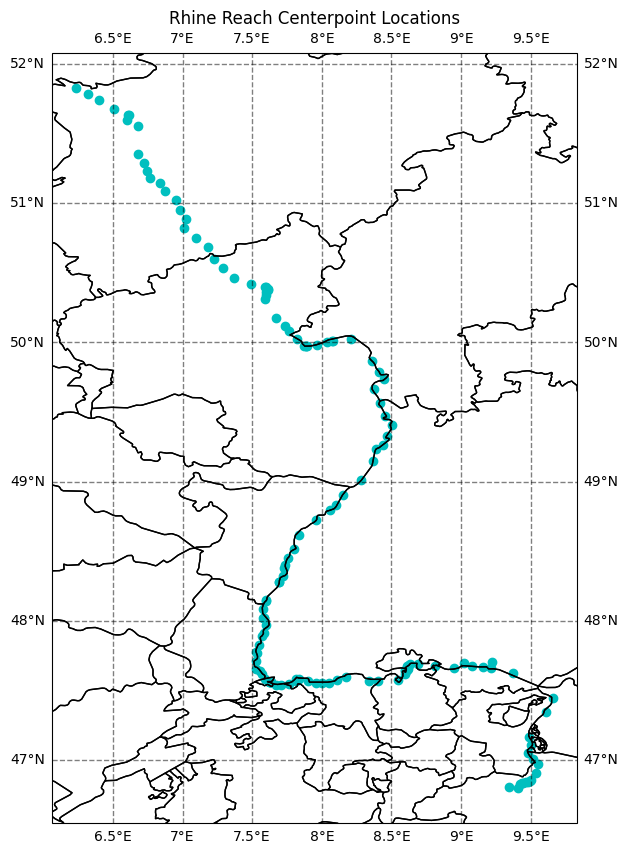

In [10]:
# Plot the location of the river
fig = plt.figure(figsize=(10,10))

# Add map elements gridlines
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black')

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = True

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# # Plot the river reach centerpoint locations
ax.scatter(ds_filtered.x, y=ds_filtered.y, color='c')

# Add the title
plt.title(f'{RIVER_NAME} Reach Centerpoint Locations');

Plot discharge

In [11]:
print(f'{RIVER_NAME} consists of the following reach identifiers')
for rid in ds_filtered.reach_id.values[:10]:
    print(str(rid))
print('...')

Rhine consists of the following reach identifiers
23261000181.0
23261000191.0
23261000201.0
23261000211.0
23261000221.0
23261000231.0
23261000241.0
23261000274.0
23261000371.0
23261000381.0
...


Plot the estimated discharge for one of these reach identifiers. First we need to get the index of the reach we're interested in.

In [12]:
reach_id = 23267000021.0
reach_idx = np.where(ds_filtered.reach_id == reach_id)[0].item()

In [13]:
# get discharge values for our reach of interest
discharge = ds_filtered.Q.values[reach_idx]

# get the times associated with the discharge values and 
# convert them into datetime objects
reference_date = datetime(2000, 1, 1, 0, 0, 0)
times = np.vectorize( lambda t: reference_date + timedelta(seconds=t))( ds_filtered.time.values[reach_idx])



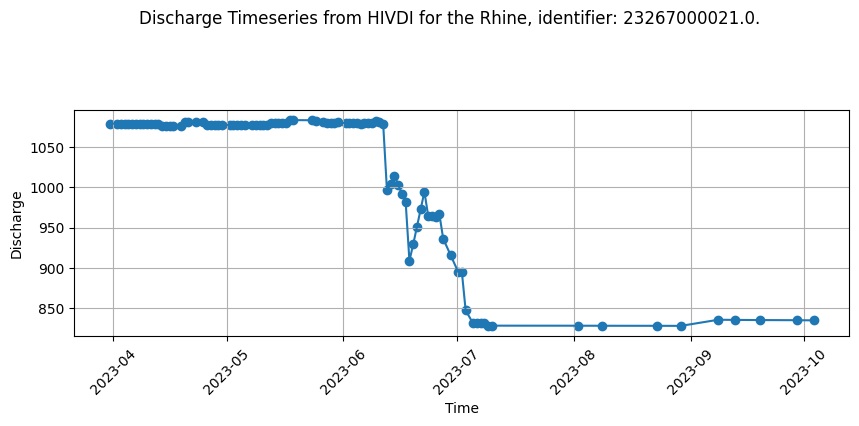

In [14]:
# Set up plot
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)

# Plot data
ax1.scatter(times, discharge);
ax1.plot(times, discharge);

# Define labels and title
ax1.set_ylabel('Discharge');
ax1.set_xlabel('Time');
plt.xticks(rotation = 45);

plt.grid()
plt.suptitle(f"Discharge Timeseries from HIVDI for the {RIVER_NAME}, identifier: {reach_id}.");